In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../funcs')

from utils import normalize_counts, get_pcs, plot_pca, plot_pca_genes, plot_pca_ax
from utils import remove_covariates
from utils import tpm_loader

import plotting as pl
from qtl.annotation import Annotation
from qtl.norm import deseq2_size_factors
import signatureanalyzer as sa

In [2]:
DATA_DIR = "../data/raw/transcriptomics/"
OUT_DIR = "../data/processed/061721"
PLOTS_DIR = "figures/data_processing"
MAPPING_FILE = "../data/processed/061721/PanCan_Participant_freeze_mapping.tsv"

RNA_OUT_DIR = os.path.join(OUT_DIR, "rna")
os.makedirs(RNA_OUT_DIR, exist_ok=True)

In [3]:
samples_df = pd.read_csv(MAPPING_FILE,sep='\t',index_col=0)
samples_df = samples_df.dropna(subset=['RNA_Tumor'])[['cohort','Proteome_Sample_ID','RNA_Tumor']]
samples_df = samples_df.reset_index().set_index("RNA_Tumor")

def assign_rna_type(x):
    if x in ("BRCA","COAD","OV"):
        return "polyA"
    else:
        return "totalRNA"
    
samples_df['rtype'] = samples_df['cohort'].apply(assign_rna_type)
samples_df = samples_df.dropna()
samples_df.head()

,participant_id,cohort,Proteome_Sample_ID,rtype
RNA_Tumor,,,,
334_R,CPT000814,BRCA,CPT000814,polyA
340_R,CPT001846,BRCA,CPT001846,polyA
25-R,01BR001,BRCA,X01BR001,polyA
350-R,01BR008,BRCA,X01BR008,polyA
345-R,01BR009,BRCA,X01BR009,polyA


## 1. Load TPM & Counts from RNA-SeQC

---

In [4]:
# Load
tpm, tpm_norm, counts, gene_name = tpm_loader(
    os.path.join(DATA_DIR, "Final_Freeze_050721_rna_tpm.parquet"), 
    os.path.join(DATA_DIR, "Final_Freeze_050721_rna_counts.parquet"),
    samples=samples_df.index
)

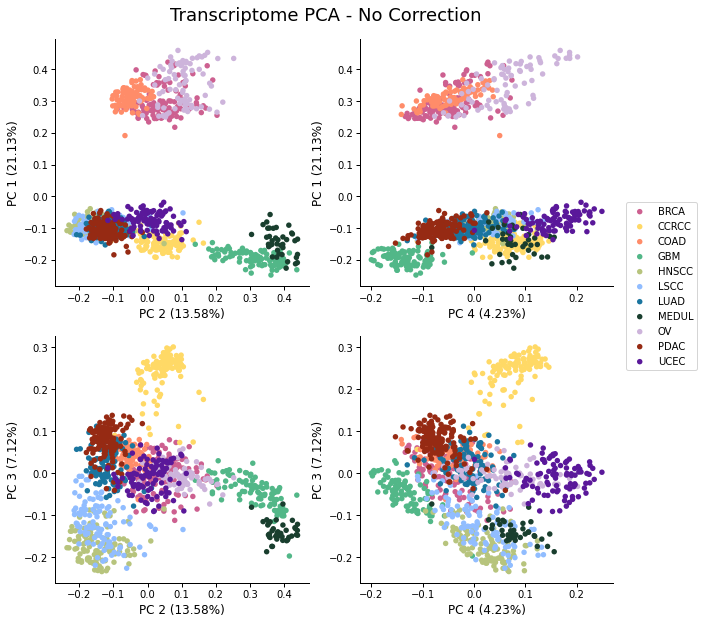

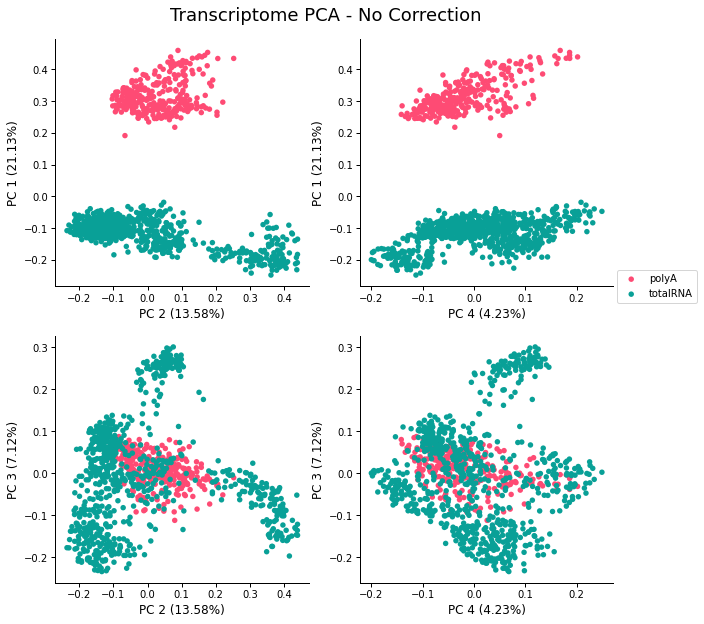

In [5]:
pl.plot_pca_grid(tpm_norm, normalize=False, title='Transcriptome PCA - No Correction', cohort_s=samples_df['cohort'], cohort_colors=pl.CPTAC_CMAP)
plt.savefig(os.path.join(PLOTS_DIR, "transcriptome_by_cohort_pca.pdf"), dpi=200, bbox_inches='tight')

pl.plot_pca_grid(tpm_norm, normalize=False, title='Transcriptome PCA - No Correction', cohort_s=samples_df['rtype'])
plt.savefig(os.path.join(PLOTS_DIR, "transcriptome_by_type_pca.pdf"), dpi=200, bbox_inches='tight')

## 2. Regress Out RNA-Type

---

#### Regress by RNA Type

In [6]:
type_dummies_df = pd.get_dummies(samples_df['rtype'])
tpm_norm_reg = remove_covariates(tpm_norm, C=type_dummies_df)

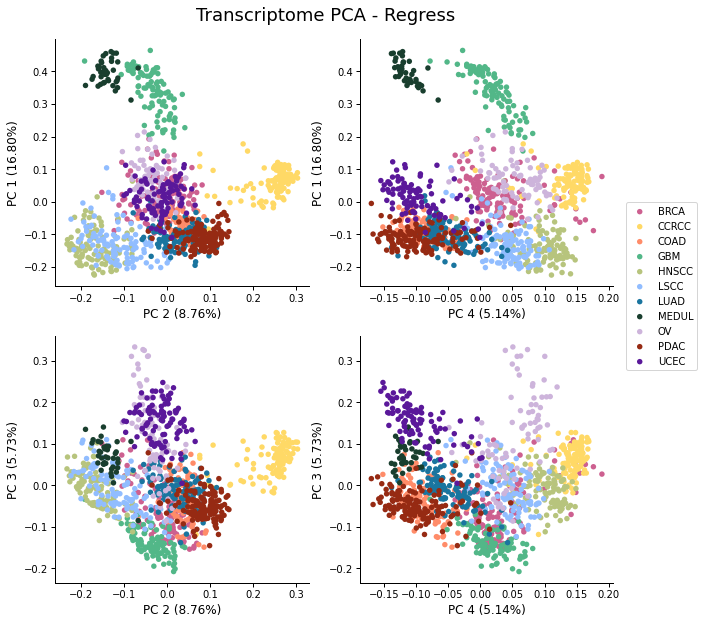

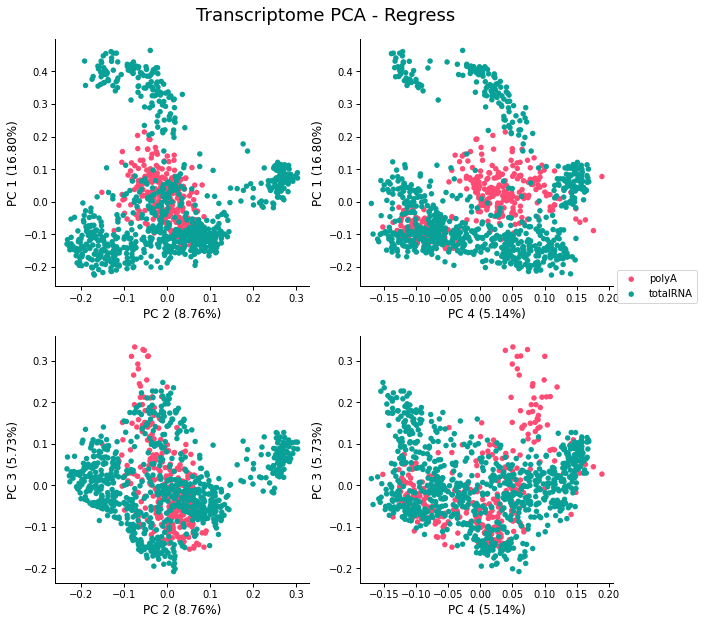

In [7]:
pl.plot_pca_grid(tpm_norm_reg, title='Transcriptome PCA - Regress', normalize=False, cohort_s=samples_df['cohort'], cohort_colors=pl.CPTAC_CMAP, C=type_dummies_df)
plt.savefig(os.path.join(PLOTS_DIR, "transcriptome_by_cohort_reg_pca.pdf"), dpi=200, bbox_inches='tight')

pl.plot_pca_grid(tpm_norm_reg, title='Transcriptome PCA - Regress', normalize=False, cohort_s=samples_df['rtype'], C=type_dummies_df)
plt.savefig(os.path.join(PLOTS_DIR, "transcriptome_by_type_reg_pca.pdf"), dpi=200, bbox_inches='tight')

#### Correct by RNA Type Using Combat

In [8]:
%load_ext rpy2.ipython

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [9]:
tpm_norm_X = tpm_norm.values

In [10]:
%%R -i tpm_norm_X -i samples_df -o tpm_norm_combat

suppressMessages(library("sva"))
tpm_norm_combat <- ComBat(dat=tpm_norm_X, batch=as.factor(samples_df$rtype))

R[write to console]: Found2batches

R[write to console]: Adjusting for0covariate(s) or covariate level(s)



Standardizing Data across genes


R[write to console]: Fitting L/S model and finding priors

R[write to console]: Finding parametric adjustments

R[write to console]: Adjusting the Data




In [11]:
tpm_norm_combat = pd.DataFrame(tpm_norm_combat, index=tpm_norm.index, columns=tpm_norm.columns)

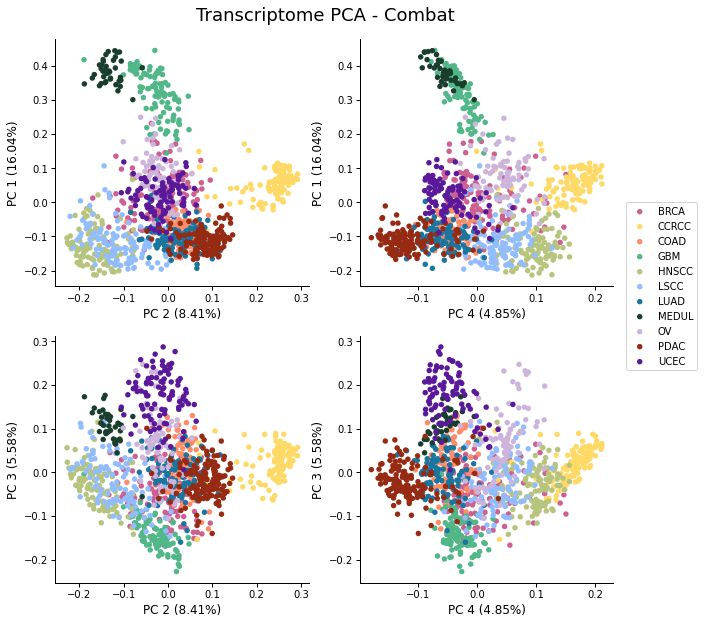

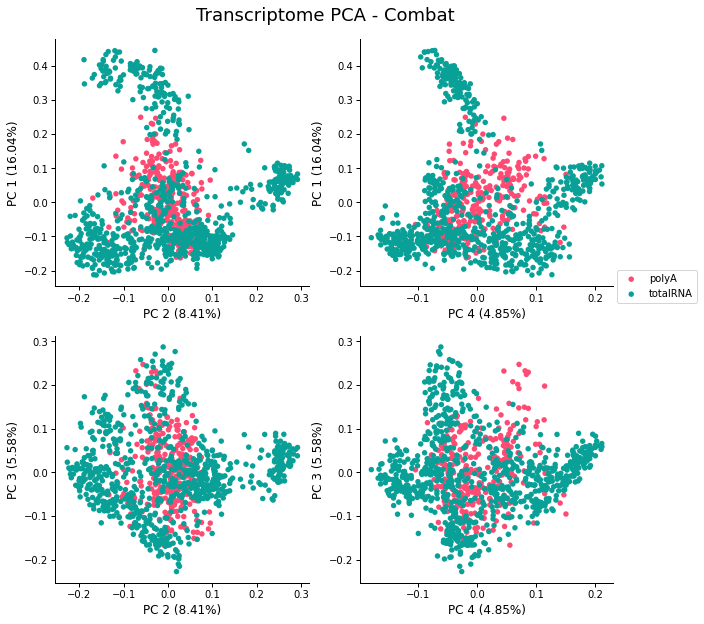

In [12]:
pl.plot_pca_grid(tpm_norm_combat, title='Transcriptome PCA - Combat', normalize=False, cohort_s=samples_df['cohort'], cohort_colors=pl.CPTAC_CMAP, C=type_dummies_df)
plt.savefig(os.path.join(PLOTS_DIR, "transcriptome_by_cohort_combat_pca.pdf"), dpi=200, bbox_inches='tight')

pl.plot_pca_grid(tpm_norm_combat, title='Transcriptome PCA - Combat', normalize=False, cohort_s=samples_df['rtype'], C=type_dummies_df)
plt.savefig(os.path.join(PLOTS_DIR, "transcriptome_by_type_combat_pca.pdf"), dpi=200, bbox_inches='tight')

In [13]:
# Standardize Namings
counts = counts.loc[:,tpm.columns].rename(columns=samples_df['Proteome_Sample_ID'].to_dict())
tpm = tpm.rename(columns=samples_df['Proteome_Sample_ID'].to_dict())
tpm_norm = tpm_norm.rename(columns=samples_df['Proteome_Sample_ID'].to_dict())
tpm_norm_reg = tpm_norm_reg.rename(columns=samples_df['Proteome_Sample_ID'].to_dict())
tpm_norm_combat = tpm_norm_combat.rename(columns=samples_df['Proteome_Sample_ID'].to_dict())

In [16]:
# Save Files
counts.to_parquet(os.path.join(RNA_OUT_DIR, "tumor_rna_counts_X.parquet"))
tpm.to_parquet(os.path.join(RNA_OUT_DIR, "tumor_rna_tpm_X.parquet"))
tpm_norm.to_parquet(os.path.join(RNA_OUT_DIR, "tumor_rna_tpm_norm_X.parquet"))
tpm_norm_reg.to_parquet(os.path.join(RNA_OUT_DIR, "tumor_rna_tpm_norm_reg_X.parquet"))
tpm_norm_combat.to_parquet(os.path.join(RNA_OUT_DIR, "tumor_rna_tpm_norm_combat_X.parquet"))

# Save Files as .tsv
counts.to_csv(os.path.join(RNA_OUT_DIR, "tumor_rna_counts_X.tsv.gz"), sep='\t')
tpm.to_csv(os.path.join(RNA_OUT_DIR, "tumor_rna_tpm_X.tsv.gz"), sep='\t')
tpm_norm.to_csv(os.path.join(RNA_OUT_DIR, "tumor_rna_tpm_norm_X.tsv.gz"), sep='\t')
tpm_norm_reg.to_csv(os.path.join(RNA_OUT_DIR, "tumor_rna_tpm_norm_reg_X.tsv.gz"), sep='\t')
tpm_norm_combat.to_csv(os.path.join(RNA_OUT_DIR, "tumor_rna_tpm_norm_combat_X.tsv.gz"), sep='\t')

In [17]:
annot = Annotation("../data/ref/genomic/gencode.v34.GRCh38.genes.collapsed_only.gtf")
gene_name['biotype'] = gene_name.reset_index()['Name'].apply(lambda x: annot.get_gene(x).biotype).values
gene_name.to_csv(os.path.join(RNA_OUT_DIR, "var_map.tsv"), sep='\t')

Genes parsed: 59808


## 3. RNA-SeQC Metrics

---

In [14]:
metrics_df = pd.read_csv(os.path.join(DATA_DIR, "Final_Freeze_050721_rnaseqc_metrics.txt"),sep='\t',index_col=0)
metrics_df = metrics_df.loc[samples_df.index].rename(index=samples_df['Proteome_Sample_ID'].to_dict())

../funcs/plotting.py:1013: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


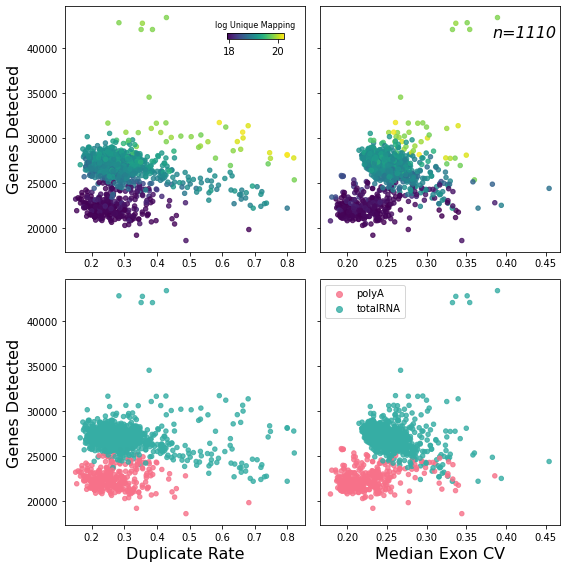

In [15]:
pl.plot_qc_rna_grid(
    metrics_df, 
    samples_df['rtype'], 
    format_ax=False
)
plt.savefig(os.path.join(PLOTS_DIR, "rnaseqc_metrics_type.pdf"), dpi=200, bbox_inches='tight')

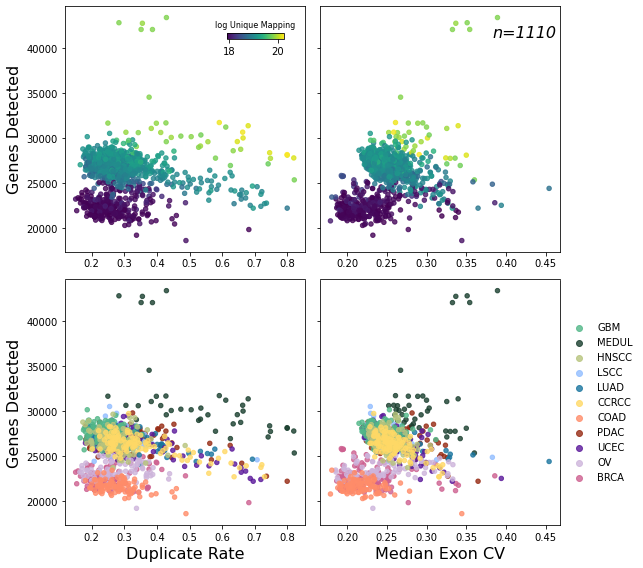

In [16]:
pl.plot_qc_rna_grid(
    metrics_df, 
    samples_df['cohort'], 
    loc='center left', 
    bbox_to_anchor=(1, 0.5), 
    frameon=False,
    format_ax=False,
    series_cdict=pl.CPTAC_CMAP
)
plt.savefig(os.path.join(PLOTS_DIR, "rnaseqc_metrics_cohort.pdf"), dpi=200, bbox_inches='tight')

In [17]:
features_df = list()
cohorts = np.unique(samples_df['cohort'])

for cohort in cohorts:
    _tpm, _, _, _ = tpm_loader(
        os.path.join(DATA_DIR, "Final_Freeze_050721_rna_tpm.parquet"), 
        os.path.join(DATA_DIR, "Final_Freeze_050721_rna_counts.parquet"),
        samples=samples_df[samples_df['cohort']==cohort].index
    )
    
    feats_df = pd.DataFrame(_tpm.index).rename(columns={"Name":"transcriptome"})
    feats_df['cohort'] = cohort
    features_df.append(feats_df)
    
    print("Cohort: {} - {} genes.".format(cohort, _tpm.shape[0]))
    
features_df = pd.concat(features_df)

Cohort: BRCA - 29773 genes.
Cohort: CCRCC - 29259 genes.
Cohort: COAD - 27023 genes.
Cohort: GBM - 31198 genes.
Cohort: HNSCC - 30269 genes.
Cohort: LSCC - 30684 genes.
Cohort: LUAD - 30120 genes.
Cohort: MEDUL - 30041 genes.
Cohort: OV - 30521 genes.
Cohort: PDAC - 30160 genes.
Cohort: UCEC - 30316 genes.


In [20]:
features_df.to_csv(os.path.join(RNA_OUT_DIR, "ensg_by_cohort.tsv"), sep='\t')

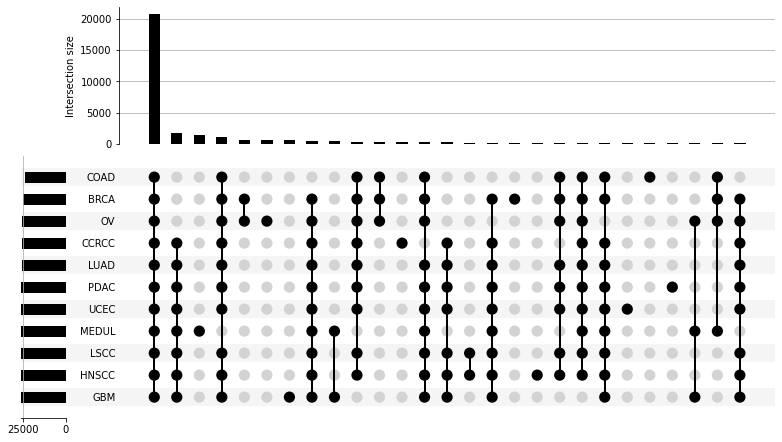

In [20]:
import upsetplot as upsetplot
from upsetplot import UpSet

min_features = 100

bc_counts_df = features_df.groupby(['transcriptome','cohort']).size().reset_index().pivot(index='transcriptome', columns='cohort', values=0)
bc_counts_mask = bc_counts_df > 0
bc_counts_mask = bc_counts_mask.groupby(list(bc_counts_mask)).size()
upsetplot.plot(bc_counts_mask[bc_counts_mask>min_features], sort_by='cardinality')
plt.savefig(os.path.join(PLOTS_DIR, "tumor_transcriptome_upset.pdf"), dpi=200, bbox_inches='tight')

## 4. Select HVG Protein Coding Genes

---

In [21]:
def subset_card(df, in_groups):
    out_groups = np.setdiff1d(df.columns,in_groups)
    sdf = df.loc[df.loc[:,out_groups].isna().sum(1)==out_groups.shape[0]]
    return np.array(sdf[sdf.sum(1)==in_groups.shape].index)

In [22]:
genes_to_use = np.intersect1d(
    tpm_norm.index,
    gene_name[gene_name['biotype']=='protein_coding'].index
)

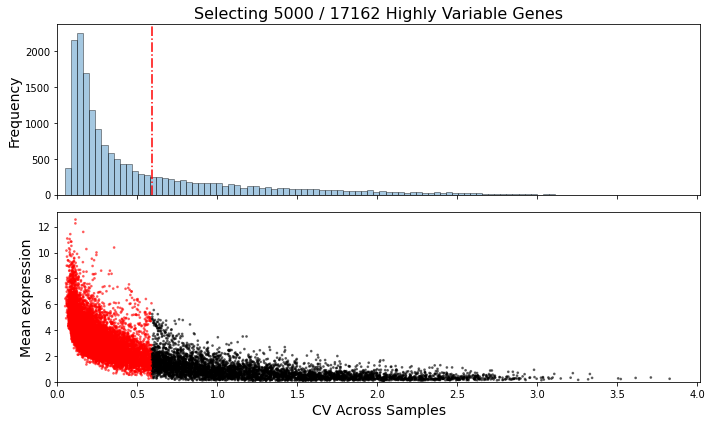

In [23]:
top_genes = pl.plot_n_top_hvg(tpm_norm.loc[genes_to_use], gene_name, n_top=5000)
plt.savefig(os.path.join(PLOTS_DIR, "tumor_transcriptome_hvg.pdf"), dpi=200, bbox_inches='tight')

In [24]:
tpm_norm_reg_hvg = tpm_norm_reg.loc[top_genes.index]
tpm_norm_reg_hvg.to_csv(os.path.join(RNA_OUT_DIR, "tumor_rna_tpm_norm_reg_filt_X.tsv.gz"), sep='\t')
tpm_norm_reg_hvg.to_parquet(os.path.join(RNA_OUT_DIR, "tumor_rna_tpm_norm_reg_filt_X.parquet"))

In [25]:
tpm_norm_combat_hvg = tpm_norm_combat.loc[top_genes.index]
tpm_norm_combat_hvg.to_csv(os.path.join(RNA_OUT_DIR, "tumor_rna_tpm_norm_combat_filt_X.tsv.gz"), sep='\t')
tpm_norm_combat_hvg.to_parquet(os.path.join(RNA_OUT_DIR, "tumor_rna_tpm_norm_combat_filt_X.parquet"))

## 5. Add RNA Coverage Numbers to Table

---

In [26]:
samples_df = pd.read_csv(MAPPING_FILE, sep='\t', index_col=0)

In [27]:
full_feat_df = pd.read_csv("../data/raw/proteomics/proteome_ptm_n_samples_coverage.tsv",sep='\t',index_col=0)
full_feat_df.head()

,Type,coverage,samples,Assay,Cohort
0,Tumor,8907,96,proteome,COAD
1,Normal,8907,95,proteome,COAD
0,Tumor,12865,45,proteome,MEDUL
1,Normal,0,0,proteome,MEDUL
0,Tumor,12941,95,proteome,UCEC


In [28]:
feats_df = {}
cohorts = np.unique(samples_df['cohort'])

c=0
for cohort in cohorts:
    # Tumor
    feats_cohort_df = {}
    rna_tumors = samples_df[samples_df['cohort']==cohort]['RNA_Tumor'].dropna().values
    feats_cohort_df['samples'] = rna_tumors.shape[0]
    
    _tpm, _, _, _ = tpm_loader(
        os.path.join(DATA_DIR, "Final_Freeze_050721_rna_tpm.parquet"), 
        os.path.join(DATA_DIR, "Final_Freeze_050721_rna_counts.parquet"),
        samples=rna_tumors
    )
    feats_cohort_df['coverage'] = _tpm.shape[0]
    feats_cohort_df['Assay'] = 'transcriptome'
    feats_cohort_df['Cohort'] = cohort
    feats_cohort_df['Type'] = 'Tumor'
    feats_df[c] = feats_cohort_df
    c+=1
        
#     # Normal
#     rna_normals = samples_df[samples_df['cohort']==cohort]['RNA_Normal'].dropna().values
#     feats_cohort_df['samples'] = rna_normals.shape[0]
    
#     _tpm, _, _, _ = tpm_loader(
#         os.path.join(DATA_DIR, "Feb2021_Freeze.gene_tpm.parquet"), 
#         os.path.join(DATA_DIR, "Feb2021_Freeze.gene_reads.parquet"),
#         samples=rna_normals
#     )
    
#     feats_cohort_df['coverage'] = _tpm.shape[0]
#     feats_cohort_df['Assay'] = 'transcriptome'
#     feats_cohort_df['Cohort'] = cohort
#     feats_df[c] = feats_cohort_df
#     feats_cohort_df['Type'] = 'Normal'
#     c+=1

In [29]:
feats_df = pd.DataFrame(feats_df).T

In [30]:
full_feat_df = pd.concat([full_feat_df,feats_df])
full_feat_df = full_feat_df[full_feat_df['Type']=='Tumor']

In [31]:
full_feat_df.to_csv(os.path.join(OUT_DIR, "tumor_pan_coverage_samples.tsv"),sep='\t')